In [1]:
# type this command in gitbash/terminal: conda install -c conda-forge fbprophet
import pandas as pd
from fbprophet import Prophet
import datetime

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('raw_files/sale_prices_state.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.tail()

,Date,CA,TX,NY,FL,IL,PA,OH,MI,GA,...,NH,RI,MT,DE,SD,AK,ND,VT,DC,WY
286,2019-11-30,563523,209358,325925,248103,203907,195918,150953,173597,203623,...,291907,303184,283654.0,257899,206301,307886,236431.0,258948,633135,252517.0
287,2019-12-31,566433,209723,326646,248825,204058,196555,151551,174330,204290,...,293356,304444,284987.0,257775,207033,306078,236708.0,259558,634526,253571.0
288,2020-01-31,569813,210164,327360,249766,204302,197133,152229,175146,205044,...,294946,305755,286402.0,257647,207831,305820,236802.0,260280,637048,254531.0
289,2020-02-29,573975,210591,328101,250981,204527,197735,152916,175948,205955,...,296965,307296,287633.0,257723,208782,303294,237099.0,260677,639504,255456.0
290,2020-03-31,578267,211199,328677,252309,204839,198377,153593,176977,206804,...,299333,308658,288867.0,257521,209684,300073,237454.0,261265,640783,256089.0


In [3]:
# Must rename the Date column to ds and one state to y in order for fbprophet to work 
state = "WA"
df = df[["Date",state]]
df = df.rename(columns = {"Date": "ds", state: "y"})

In [4]:
model = Prophet()
model.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [5]:
## Trying to predict housing sales prices 3 years (730 days) into the future. Our dataset stops at 3/31/20. Now our model will predict up to 3/31/2021. 
future = model.make_future_dataframe(periods=1095)
future.tail()

,ds
1381,2023-03-27
1382,2023-03-28
1383,2023-03-29
1384,2023-03-30
1385,2023-03-31


In [6]:
forecast = model.predict(future)
forecast.to_csv(f'{state}_Prediction.csv')
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1381,2023-03-27,527206.805608,495065.092371,561861.800692
1382,2023-03-28,527380.862503,496510.005140,560957.121742
1383,2023-03-29,527475.925315,496600.380765,561996.903570
1384,2023-03-30,527493.140494,496829.724080,563019.468126
1385,2023-03-31,527435.834100,497327.014518,562748.034742


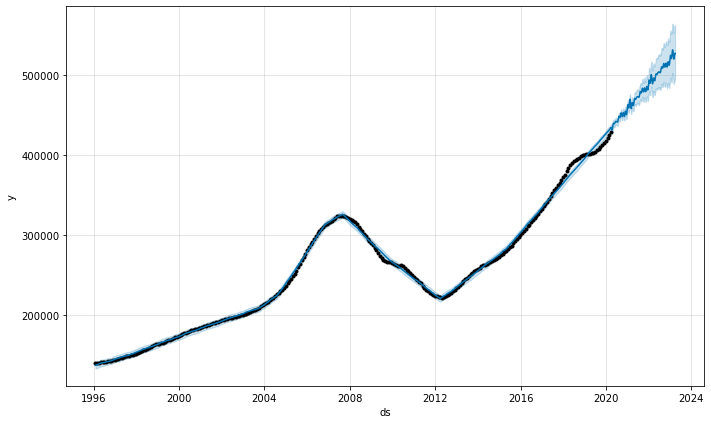

In [7]:
fig1 = model.plot(forecast)

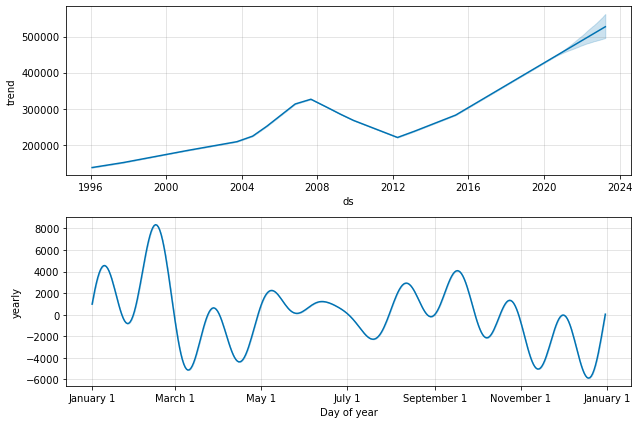

In [8]:
fig2 = model.plot_components(forecast)

In [9]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='8370 days', period='180 days', horizon = '365 days')
df_cv.to_csv(f'{state}_Cross_Validation.csv')
df_cv
# Performing a cross validation: the training set is from 1/31/1996 - 4/1/2019 
# The goal is to forecast over a 365 days horizon: it would be from 4/30/2019 to 3/31/2020 

INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-01 00:00:00 and 2019-04-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-04-30,411608.975860,408055.203479,414925.659986,402276,2019-04-01
1,2019-05-31,414237.460319,410727.626819,418020.578750,403121,2019-04-01
2,2019-06-30,416838.665989,413125.364615,420254.215917,404490,2019-04-01
3,2019-07-31,419311.834762,415468.215490,422763.837546,406338,2019-04-01
4,2019-08-31,421866.853197,418019.426920,425535.588395,408416,2019-04-01
5,2019-09-30,424454.137603,420153.199204,428206.499264,410440,2019-04-01
6,2019-10-31,427109.061715,422836.924020,431123.896506,412493,2019-04-01
7,2019-11-30,429470.706793,424830.564216,433989.506953,415000,2019-04-01
8,2019-12-31,432083.955018,427173.208713,436754.442506,418034,2019-04-01
9,2020-01-31,435052.409812,429772.582248,440441.553091,421340,2019-04-01


In [10]:
# Analyzing prediction performance 
# MSE: Mean squared error 
# RMSE: Root mean squared error 
# MAE: Mean absolute error 
# MAPE: Mean absolute percent error 
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.to_csv(f'{state}_Diagnostics.csv')
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,29 days,8.710444e+07,9332.975860,9332.975860,0.023200,0.023200,0.0
1,60 days,1.235757e+08,11116.460319,11116.460319,0.027576,0.027576,0.0
2,90 days,1.524896e+08,12348.665989,12348.665989,0.030529,0.030529,0.0
3,121 days,1.683204e+08,12973.834762,12973.834762,0.031929,0.031929,0.0
4,152 days,1.809255e+08,13450.853197,13450.853197,0.032934,0.032934,0.0
5,182 days,1.963961e+08,14014.137603,14014.137603,0.034144,0.034144,0.0
6,213 days,2.136293e+08,14616.061715,14616.061715,0.035433,0.035433,0.0
7,243 days,2.094014e+08,14470.706793,14470.706793,0.034869,0.034869,0.0
8,274 days,1.974012e+08,14049.955018,14049.955018,0.033610,0.033610,0.0
9,305 days,1.880302e+08,13712.409812,13712.409812,0.032545,0.032545,0.0


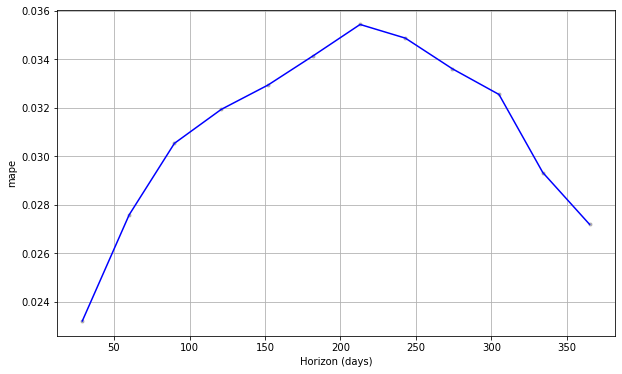

In [11]:
from fbprophet.plot import plot_cross_validation_metric
fig_mape = plot_cross_validation_metric(df_cv, metric='mape')

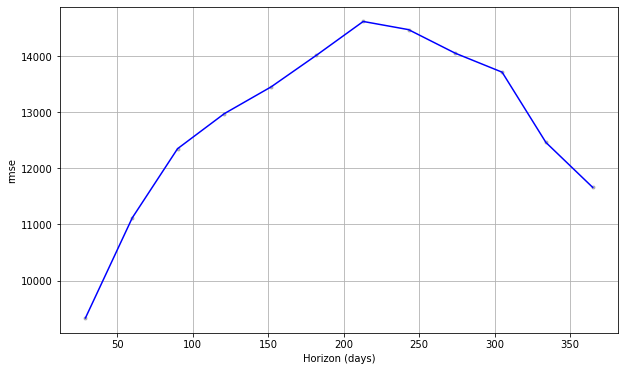

In [12]:
from fbprophet.plot import plot_cross_validation_metric
fig_rmse = plot_cross_validation_metric(df_cv, metric='rmse')

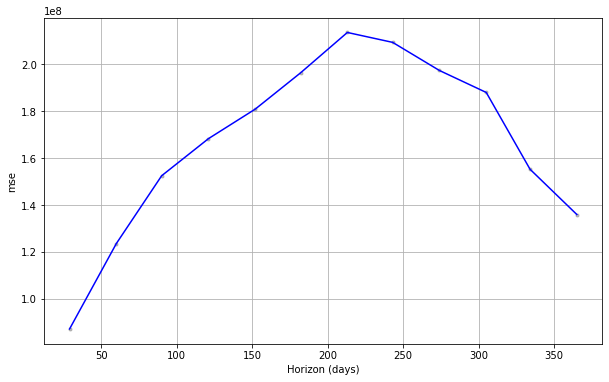

In [13]:
from fbprophet.plot import plot_cross_validation_metric
fig_mse = plot_cross_validation_metric(df_cv, metric='mse')